# 8. GPE auto-training + GSA using external dataset (from publication) loaded from json file

In [1]:
import os

import torch
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean

from GPErks.constants import DEFAULT_RANDOM_SEED
from GPErks.gp.data.dataset import Dataset
from GPErks.gp.experiment import GPExperiment
from GPErks.gp.mean import LinearMean
from GPErks.perks.gsa import SobolGSA
from GPErks.serialization.path import posix_path
from GPErks.train.emulator import GPEmulator
from GPErks.utils.random import set_seed

/Users/slongobardi/Projects/GPErks/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = DEFAULT_RANDOM_SEED
set_seed(seed)

In [4]:
# This new method loads your dataset into a dictionary where keys = features, values = Dataset objects
# (each Dataset is built to create the experiment that will emulate the corresponding scalar feature (key))
datasets = Dataset.build_from_file(posix_path(os.getcwd(), "data", "datasets", "Stefano_16p.json"))
features = list(datasets.keys())
print(features)  # available features to be emulated

['EDV', 'ESV', 'SV', 'EF', 'IVCT', 'ET', 'IVRT', 'Tdiast', 'PeakP', 'Tpeak', 'ESP', 'maxdP', 'mindP', 'Tau']


Note: if you want to create a .json file containing your dataset, you can do so like this:
X = np.loadtxt(data_dir / "X.txt", dtype=float)
Y = np.loadtxt(data_dir / "Y.txt", dtype=float)
xlabels = read_labels_from_file(data_dir / "xlabels.txt")
ylabels = read_labels_from_file(data_dir / "ylabels.txt")
data_dct = {
    "X_train": X.tolist(),
    "Y_train": Y.tolist(),
    "X_val": X_val.tolist(), # (if available, otherwise can omit this dct key)
    "Y_val": Y_val.tolist(), # (if available, otherwise can omit this dct key)
    "X_test": X_test.tolist(), # (if available, otherwise can omit this dct key)
    "Y_test": Y_test.tolist(), # (if available, otherwise can omit this dct key)
    "x_labels": xlabels,  # (if available, otherwise can omit this dct key)
    "y_labels": ylabels,  # (if available, otherwise can omit this dct key)
    "l_bounds": a list here (if available, otherwise can omit this dct key)
    "u_bounds": a list here (if available, otherwise can omit this dct key)
    "info": "A short description about the dataset"
}
with open(Path(os.getcwd())/"datasetname.json", "w") as f:
    json.dump(data_dct, f, indent=4)

Also note that there is already a utility function that does this for you:
from GPErks.utils.jsonfiles import create_json_dataset_from_arrays

In [5]:
feature = "EDV"  # we will emulate just one feature as an example
print(f"\nEmulating target feature: {feature}")

# GPE auto-training
dataset = datasets[feature]
likelihood = GaussianLikelihood()
mean = LinearMean(degree=1, input_size=dataset.input_size, bias=True)
covariance = ScaleKernel(MaternKernel(ard_num_dims=dataset.input_size))
experiment = GPExperiment(
    dataset,
    likelihood,
    mean,
    covariance,
    seed=seed
)
device = "cuda" if torch.cuda.is_available() else "cpu"
emulator = GPEmulator(experiment, device)
emulator.train_auto()
emulator.hyperparameters()


Emulating target feature: EDV


INFO:2025-05-16 17:08:45,737:emulator:train_auto:L205: Training emulator...
INFO:2025-05-16 17:08:49,764:emulator:train_auto:L207: Trained emulator.
INFO:2025-05-16 17:08:49,765:emulator:train_auto:L209: Saving model...
INFO:2025-05-16 17:08:49,768:emulator:train_auto:L214: Saved model.



Bias: -4.1422
Weights: tensor([-4.0596, -0.0233, -0.0120, -0.1738,  0.6366,  0.0304, -0.0488, -0.5169,
         2.3549, -0.3759,  1.2784,  3.2430, -0.0410,  0.9869,  1.2497, -0.2960])
Outputscale: 2.4444
Lengthscales: tensor([ 0.5251,  4.2436, 36.7171,  4.0739,  3.3087, 35.8495, 34.9706,  1.7403,
         0.9238,  2.9991,  1.4824,  0.6466, 41.0917,  1.3813,  1.7957,  8.7669])
Likelihood noise: 0.0001


In [6]:
# GPE-based GSA
gsa = SobolGSA(dataset, n=1024, seed=seed)
gsa.estimate_Sobol_indices_with_emulator(emulator, n_draws=1000)
gsa.correct_Sobol_indices(threshold=1e-2)
gsa.summary()

/Users/slongobardi/Projects/GPErks/.venv/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/slongobardi/Projects/GPErks/.venv/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/slongobardi/Projects/GPErks/.venv/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


                STi
Parameter          
AMPL       0.000000
C1         0.028453
Ca50       0.209398
DCA        0.432353
RT50       0.000000
TP         0.000000
TRPN50     0.067450
Tref       0.000000
Z          0.000000
beta1      0.000000
kXB        0.000000
koff       0.072234
nTRPN      0.357169
nXB        0.052619
p          0.022947
pao        0.000000
                 Si
Parameter          
AMPL       0.000000
C1         0.012115
Ca50       0.118120
DCA        0.309012
RT50       0.000000
TP         0.000000
TRPN50     0.029426
Tref       0.000000
Z          0.000000
beta1      0.000000
kXB        0.000000
koff       0.033971
nTRPN      0.267593
nXB        0.026169
p          0.011966
pao        0.000000


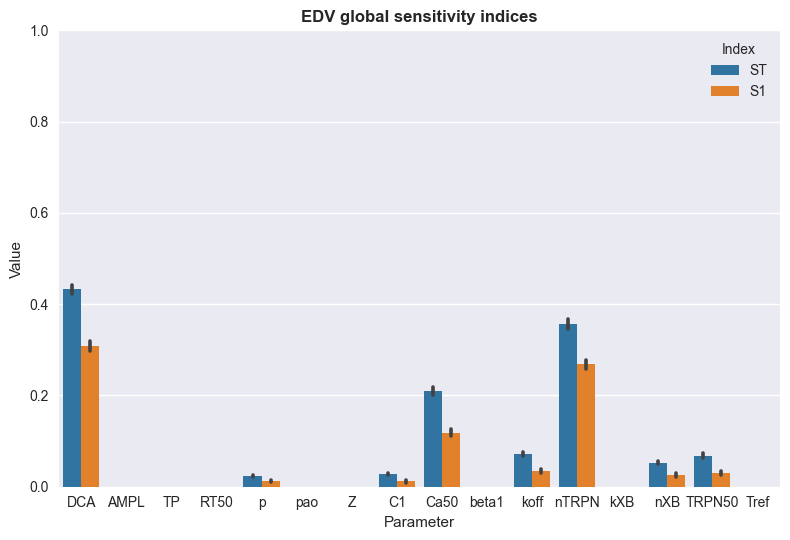

In [7]:
# plotting estimated Sobol' indices
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")
fig, axis = plt.subplots(1, 1)
gsa.plot(axis=axis, type="bar", colors="tab10")
axis.set_title(f"{feature} global sensitivity indices", fontweight="bold")
fig.tight_layout()
plt.show()